# Libs & Util

In [1]:
# Extracting Features
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import librosa
import noisereduce as nr
import IPython
from tqdm.notebook import tqdm
import json

# Training neural networks
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import *
from sklearn.model_selection import train_test_split

# Live detection
import pyaudio
from IPython.display import clear_output
import wave

# ms per chunk
STEP = 50
PATH = "whistle_dataset/"

Using TensorFlow backend.
C:\Users\dverm\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\dverm\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\dverm\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\dverm\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

# Extracting features

## Chunk processor

>The chunk processor will get a sample with a feature type, and will utilize these to process said chunk into features. The chunk processor is used in both featurizers.

In [2]:
# def chunk_processor(sample, sample_rate, feature_type, target, false_window = 1, true_window= 1/50):
#def chunk_processor(sample, sample_rate, feature_type, target, false_window = 10, true_window= 1/5):
def chunk_processor(sample, sample_rate, feature_type, target, false_window = 25, true_window= 1/2):
    
    # get correct window variable
    if target:
        window = true_window
    else:
        window = false_window
        
    # calculate chunk size
    chunk = int((sample_rate / 1000) * STEP)
    
    # iterate over sample and fetch features
    for i in tqdm(range(0, len(sample) - chunk, int(chunk * window)), leave=False):
        if feature_type == "fft":
            chunk_features = np.mean(np.abs(librosa.stft(sample[i:i+chunk], n_fft=512, hop_length=256, win_length=512)).T, axis=0)
        elif feature_type == "mfcc":
            chunk_features = np.mean(librosa.feature.mfcc(y=sample[i:i+chunk], sr=sample_rate, n_mfcc=40).T, axis=0)
        
        try:
            features = np.append(features, np.array([chunk_features]), axis=0)
        except:
            features = np.array([chunk_features])
            
    return features, np.full(len(features), int(target))

## Featurizer V1

> Featurizer 1 only uses the whistle, and the segments before and after (same length). This is how a 2:1 label ratio is managed.

In [3]:
def build_feature_dataframe_v1(feature_type, denoise=False):
    """Convert all whistles and small fragments before and after said whistles into features"""
    
    # See if csv has been calculated before (saving time)
    try:
        df = pd.read_csv("data_v1_" + feature_type + "_" + str(denoise) + ".csv", index_col=0)
        print("Dataframe succesfully loaded from csv!")
        return df
    except:
        pass
    
    # get the labels
    target = []
    with open(PATH + "whistledb.json") as json_file:
        labels = json.load(json_file)["audioFiles"]
        labels = {entry["path"] : entry["channels"][1]["whistleLabels"] for entry in labels}
    
    # iterate over all audiofiles
    for file_name in tqdm(os.listdir(PATH)):
        # skip json file
        if file_name.split(".")[-1] != "wav":
            continue

        # load file & meta data
        sample, sample_rate = librosa.load(PATH + file_name, sr=None)
        if denoise == True:
            sample = nr.reduce_noise(y=sample,  y_noise=sample[0:5000], sr=sample_rate)

        # for all positive intervals get part before and after aswell and featurize
        for times in tqdm(labels[file_name], leave=False):
            delta_time = times["end"] - times["start"]
            
            label = False
            for i in range(times["start"]-delta_time, times["end"]+delta_time, delta_time):
                if i >= 0 and i + delta_time <= len(sample):
                    features, targets = chunk_processor(sample[i:i+delta_time], sample_rate, feature_type, label, 
                                                        false_window = 1/5, true_window= 1/5)
                    label = not(label)
                    try:
                        out = np.append(out, features, axis=0)
                        target = np.append(target, targets)
                    except:
                        out = features
                        target = targets
                else:
                    print(file_name, i, 'no fit ;(')

    # save them in dataframe
    df = pd.DataFrame(out)
    df=(df-df.min())/(df.max()-df.min())
    df.insert(0, "target", target)
    df.to_csv("data_v1_" + feature_type + "_" + str(denoise) + ".csv")
    return df

## Featurizer V2

> Featurizer 2 utilises two different overlap values. True labels have 1/2 overlap, meaning that sequential samples have 50% overlap. False labels have a overlap value of 25, meaning that after each sample taken 24 are skipped. This insures that a 2:1 label ratio is kept while still taking a more fair representation of the dataset.

In [4]:
def build_feature_dataframe_v2(feature_type, denoise=False):
    
    # See if csv has been calculated before (saving time)
    try:
        df = pd.read_csv("data_v2_" + feature_type + "_" + str(denoise) + ".csv", index_col=0)
        print("Dataframe succesfully loaded from csv!")
        return df
    except:
        pass
    
    # get the labels
    target = []
    with open(PATH + "whistledb.json") as json_file:
        labels = json.load(json_file)["audioFiles"]
        labels = {entry["path"] : entry["channels"][1]["whistleLabels"] for entry in labels}
    
    # iterate over all audiofiles
    for file_name in tqdm(os.listdir(PATH)):
        # skip json file
        if file_name.split(".")[-1] != "wav":
            continue

        # load file & meta data
        sample, sample_rate = librosa.load(PATH + file_name, sr=None)
        if denoise == True:
            sample = nr.reduce_noise(y=sample,  y_noise=sample[0:5000], sr=sample_rate)
        
        # create time intervals
        times_list = [0]
        for times in labels[file_name]:
            times_list += [times["start"], times["end"]]
        if times_list[-1] < len(sample):
            times_list.append(len(sample))
        
        label = False
        for i in tqdm(range(len(times_list)-1), leave=False):
            features, targets = chunk_processor(sample[times_list[i]:times_list[i+1]], sample_rate, feature_type, label)
            label = not(label)
            try:
                out = np.append(out, features, axis=0)
                target = np.append(target, targets)
            except:
                out = features
                target = targets

    # save them in dataframe
    df = pd.DataFrame(out)
    df=(df-df.min())/(df.max()-df.min())
    df.insert(0, "target", target)
    df.to_csv("data_v2_" + feature_type + "_" + str(denoise) + ".csv")
    return df

In [5]:
def build_features(version, feature_type, denoise):
    if version == 1:
        return build_feature_dataframe_v1(feature_type, denoise)
    elif version == 2:
        return build_feature_dataframe_v2(feature_type, denoise)
    else:
        print("invalid version")

In [6]:
mass_data = build_features(1, "mfcc", False)
print("True label ratio:", round((len(mass_data[mass_data["target"] == 1]) / len(mass_data["target"])) * 100, 1),"%")

WhistleTest_tuhhnao16.wav 28116000 no fit ;(

True label ratio: 33.5 %


## Dataset debugging

> The following code allows for any whistle sample to be extracted in order to check if they are labeled correctly.

In [7]:
# Choose recording
i = -1
fname = os.listdir(PATH)[i]
print(fname)

with open(PATH + "whistledb.json") as json_file:
    labels = json.load(json_file)["audioFiles"]
    labels = {entry["path"] : entry["channels"][1]["whistleLabels"] for entry in labels}
print(labels[fname], len(labels[fname]))

sample_tts, sr = librosa.load(PATH + fname, sr=None)

WhistleTest_tuhhnao16.wav
[{'start': 14930000, 'end': 14970000}, {'start': 19186000, 'end': 19250000}, {'start': 19840000, 'end': 19930000}, {'start': 20339000, 'end': 20400000}, {'start': 20918000, 'end': 20955000}, {'start': 21082000, 'end': 21140000}, {'start': 21463000, 'end': 21520000}, {'start': 23044000, 'end': 23110000}, {'start': 23676000, 'end': 23730000}, {'start': 24353000, 'end': 24410000}, {'start': 27023000, 'end': 27060000}, {'start': 27830000, 'end': 27880000}, {'start': 28075000, 'end': 28116000}] 13


In [8]:
# Choose whistle number
i = -1
print(os.listdir(PATH))
print(labels[fname][i]["start"],labels[fname][i]["end"])

IPython.display.Audio(sample_tts[labels[fname][i]["start"]:labels[fname][i]["end"]], rate=sr)

['HTWK_Dutch_05_04_2017-2.wav', 'HTWK_Dutch_05_04_2017.wav', 'HTWK_HULKs_1930_2016_04_29.wav', 'Lab_Fox40_vs_printed.wav', 'LUnitedvsUPenn20170728.wav', 'LUnitedvsUPenn20170728Half2.wav', 'SRC_Dutch_05-04-2017.wav', 'TestBHuman_03_05_2017_1413.wav', 'whistledb.json', 'WhistleTest_tuhhnao12.wav', 'WhistleTest_tuhhnao16.wav']
28075000 28116000


# Training neural networks

## Support functions

In [9]:
# Randomise and split dataframe into X and Y
def feature_target_split(df, shuffle=True):
    if shuffle:
        df = df.sample(frac = 1)
    
    dataset = df.values
    X = dataset[:,1:].astype(float)
    
    Y = dataset[:,0]
    encoder = sklearn.preprocessing.LabelEncoder()
    encoder.fit(Y)
    Y = encoder.transform(Y)
    
    return X, Y

## Neural networks

In [10]:
def two_layer_integrated(X):
    inputs = Input(shape= (X.shape[1],))
    layer = Dense(128, activation="relu")(inputs)
    outputs = Dense(1, activation="sigmoid")(layer)
    model = Model(inputs, outputs)
    model.compile(loss = "binary_crossentropy",optimizer = "adam",metrics = ["acc"])
    mc = ModelCheckpoint("best_model_simple.hdf5", monitor="val_loss", verbose=1, save_best_only=True, mode="min")
    return model, mc

Dataframe succesfully loaded from csv!
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 12012 samples, validate on 3003 samples
Epoch 1/200
12012/12012 [==============================] - 0s 27us/step - loss: 0.3643 - acc: 0.8531 - val_loss: 0.2323 - val_acc: 0.9281

Epoch 00001: val_loss improved from inf to 0.23229, saving model to best_model_simple.hdf5
Epoch 2/200
12012/12012 [==============================] - 0s 19us/step - loss: 0.1890 - acc: 0.9313 - val_loss: 0.1565 - val_acc: 0.9414

Epoch 00002: val_loss improved from 0.23229 to 0.15651, saving model to best_model_simple.hdf5
Epoch 3/200
12012/12012 [==============================] - 0s 19us/step - loss: 0.1478 - acc: 0.9461 - val_loss: 0.1292 - val_acc: 0.9524

Epoch 00003: val_loss improved from 0.15651 to 0.12919, saving model to best_model_simple.hdf5
Epoch 4/200
12012/12012 [==============================] - 0s 19us/step - loss: 0.1273 - acc: 0.9535 - val_loss: 0.1105

12012/12012 [==============================] - 0s 20us/step - loss: 0.0377 - acc: 0.9860 - val_loss: 0.0391 - val_acc: 0.9860

Epoch 00036: val_loss improved from 0.04118 to 0.03907, saving model to best_model_simple.hdf5
Epoch 37/200
12012/12012 [==============================] - 0s 22us/step - loss: 0.0382 - acc: 0.9854 - val_loss: 0.0440 - val_acc: 0.9833

Epoch 00037: val_loss did not improve from 0.03907
Epoch 38/200
12012/12012 [==============================] - 0s 20us/step - loss: 0.0381 - acc: 0.9852 - val_loss: 0.0375 - val_acc: 0.9860

Epoch 00038: val_loss improved from 0.03907 to 0.03745, saving model to best_model_simple.hdf5
Epoch 39/200
12012/12012 [==============================] - 0s 19us/step - loss: 0.0372 - acc: 0.9861 - val_loss: 0.0396 - val_acc: 0.9847

Epoch 00039: val_loss did not improve from 0.03745
Epoch 40/200
12012/12012 [==============================] - 0s 18us/step - loss: 0.0353 - acc: 0.9869 - val_loss: 0.0398 - val_acc: 0.9837

Epoch 00040: val_loss

12012/12012 [==============================] - 0s 25us/step - loss: 0.0224 - acc: 0.9920 - val_loss: 0.0248 - val_acc: 0.9897

Epoch 00117: val_loss improved from 0.02575 to 0.02485, saving model to best_model_simple.hdf5
Epoch 118/200
12012/12012 [==============================] - 0s 20us/step - loss: 0.0208 - acc: 0.9922 - val_loss: 0.0301 - val_acc: 0.9893

Epoch 00118: val_loss did not improve from 0.02485
Epoch 119/200
12012/12012 [==============================] - 0s 20us/step - loss: 0.0212 - acc: 0.9928 - val_loss: 0.0231 - val_acc: 0.9903

Epoch 00119: val_loss improved from 0.02485 to 0.02308, saving model to best_model_simple.hdf5
Epoch 120/200
12012/12012 [==============================] - 0s 22us/step - loss: 0.0197 - acc: 0.9922 - val_loss: 0.0253 - val_acc: 0.9893

Epoch 00120: val_loss did not improve from 0.02308
Epoch 121/200
12012/12012 [==============================] - 0s 21us/step - loss: 0.0206 - acc: 0.9921 - val_loss: 0.0283 - val_acc: 0.9880

Epoch 00121: val_


Epoch 00199: val_loss did not improve from 0.01547
Epoch 200/200
12012/12012 [==============================] - 0s 19us/step - loss: 0.0109 - acc: 0.9960 - val_loss: 0.0171 - val_acc: 0.9930

Epoch 00200: val_loss did not improve from 0.01547


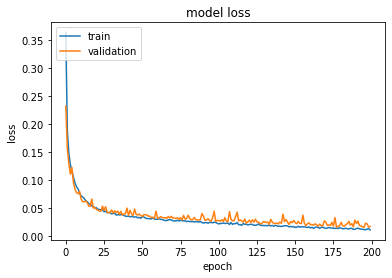

In [11]:
def train(X_train, X_test, Y_train, Y_test, version, feature_type, denoise, plot=False):
    
    # model training
    model, model_checkpoint = two_layer_integrated(X_train)
    history = model.fit(X_train, Y_train ,epochs=200, callbacks=[model_checkpoint], batch_size=32, 
                        validation_data=(X_test, Y_test))

    # load the best model weights
    model.load_weights('best_model_simple.hdf5')
    
    # save model
    model.save("model_v" + str(version) + "_" + feature_type + "_" + str(denoise) + ".h5")

    # summarize history for loss
    if plot:
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
        
    return model
        
def train_model(version, feature_type, denoise):
    # load data
    mass_data = build_features(version, feature_type, denoise)
    
    # train test split
    X, Y = feature_target_split(mass_data)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, 
                                                        random_state=12, shuffle=True)
    
    return X_test, Y_test, train(X_train, X_test, Y_train, Y_test, version, feature_type, denoise, plot=True)
        

X_test, Y_test, model = train_model(1, "mfcc", False)

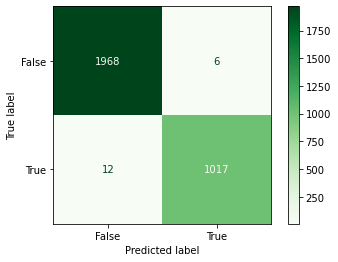

In [24]:
cm = confusion_matrix(Y_test, [1 if prediction > .5 else 0 for prediction in model.predict(X_test)[:,0]])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])
disp.plot(cmap="Greens")

## K-fold validation

Dataframe succesfully loaded from csv!
Train on 12012 samples, validate on 3003 samples
Epoch 1/200
12012/12012 [==============================] - 1s 45us/step - loss: 0.3125 - acc: 0.8875 - val_loss: 0.1955 - val_acc: 0.9158

Epoch 00001: val_loss improved from inf to 0.19547, saving model to best_model_simple.hdf5
Epoch 2/200
12012/12012 [==============================] - 0s 30us/step - loss: 0.1634 - acc: 0.9401 - val_loss: 0.1376 - val_acc: 0.9527

Epoch 00002: val_loss improved from 0.19547 to 0.13762, saving model to best_model_simple.hdf5
Epoch 3/200
12012/12012 [==============================] - 0s 35us/step - loss: 0.1328 - acc: 0.9508 - val_loss: 0.1241 - val_acc: 0.9604

Epoch 00003: val_loss improved from 0.13762 to 0.12408, saving model to best_model_simple.hdf5
Epoch 4/200
12012/12012 [==============================] - 0s 33us/step - loss: 0.1198 - acc: 0.9580 - val_loss: 0.1124 - val_acc: 0.9604

Epoch 00004: val_loss improved from 0.12408 to 0.11245, saving model to bes


Epoch 00036: val_loss did not improve from 0.04539
Epoch 37/200
12012/12012 [==============================] - 0s 35us/step - loss: 0.0440 - acc: 0.9835 - val_loss: 0.0485 - val_acc: 0.9807

Epoch 00037: val_loss did not improve from 0.04539
Epoch 38/200
12012/12012 [==============================] - 0s 34us/step - loss: 0.0408 - acc: 0.9848 - val_loss: 0.0421 - val_acc: 0.9840

Epoch 00038: val_loss improved from 0.04539 to 0.04212, saving model to best_model_simple.hdf5
Epoch 39/200
12012/12012 [==============================] - 0s 32us/step - loss: 0.0405 - acc: 0.9851 - val_loss: 0.0441 - val_acc: 0.9817

Epoch 00039: val_loss did not improve from 0.04212
Epoch 40/200
12012/12012 [==============================] - 0s 32us/step - loss: 0.0392 - acc: 0.9846 - val_loss: 0.0410 - val_acc: 0.9867

Epoch 00040: val_loss improved from 0.04212 to 0.04103, saving model to best_model_simple.hdf5
Epoch 41/200
12012/12012 [==============================] - 0s 32us/step - loss: 0.0390 - acc: 0

12012/12012 [==============================] - 0s 30us/step - loss: 0.0238 - acc: 0.9914 - val_loss: 0.0302 - val_acc: 0.9907

Epoch 00076: val_loss did not improve from 0.02809
Epoch 77/200
12012/12012 [==============================] - 0s 28us/step - loss: 0.0227 - acc: 0.9917 - val_loss: 0.0296 - val_acc: 0.9860

Epoch 00077: val_loss did not improve from 0.02809
Epoch 78/200
12012/12012 [==============================] - 0s 29us/step - loss: 0.0226 - acc: 0.9920 - val_loss: 0.0299 - val_acc: 0.9860

Epoch 00078: val_loss did not improve from 0.02809
Epoch 79/200
12012/12012 [==============================] - 0s 29us/step - loss: 0.0223 - acc: 0.9915 - val_loss: 0.0261 - val_acc: 0.9900

Epoch 00079: val_loss improved from 0.02809 to 0.02610, saving model to best_model_simple.hdf5
Epoch 80/200
12012/12012 [==============================] - 0s 29us/step - loss: 0.0225 - acc: 0.9918 - val_loss: 0.0277 - val_acc: 0.9910

Epoch 00080: val_loss did not improve from 0.02610
Epoch 81/200
1

12012/12012 [==============================] - 0s 30us/step - loss: 0.0146 - acc: 0.9953 - val_loss: 0.0210 - val_acc: 0.9923

Epoch 00116: val_loss did not improve from 0.02006
Epoch 117/200
12012/12012 [==============================] - 0s 30us/step - loss: 0.0149 - acc: 0.9957 - val_loss: 0.0327 - val_acc: 0.9867

Epoch 00117: val_loss did not improve from 0.02006
Epoch 118/200
12012/12012 [==============================] - 0s 30us/step - loss: 0.0161 - acc: 0.9946 - val_loss: 0.0220 - val_acc: 0.9910

Epoch 00118: val_loss did not improve from 0.02006
Epoch 119/200
12012/12012 [==============================] - 0s 31us/step - loss: 0.0142 - acc: 0.9957 - val_loss: 0.0205 - val_acc: 0.9927

Epoch 00119: val_loss did not improve from 0.02006
Epoch 120/200
12012/12012 [==============================] - 0s 30us/step - loss: 0.0141 - acc: 0.9961 - val_loss: 0.0234 - val_acc: 0.9890

Epoch 00120: val_loss did not improve from 0.02006
Epoch 121/200
12012/12012 [===========================

12012/12012 [==============================] - 0s 30us/step - loss: 0.0067 - acc: 0.9982 - val_loss: 0.0131 - val_acc: 0.9963

Epoch 00196: val_loss improved from 0.01322 to 0.01309, saving model to best_model_simple.hdf5
Epoch 197/200
12012/12012 [==============================] - 0s 30us/step - loss: 0.0063 - acc: 0.9987 - val_loss: 0.0133 - val_acc: 0.9963

Epoch 00197: val_loss did not improve from 0.01309
Epoch 198/200
12012/12012 [==============================] - 0s 31us/step - loss: 0.0061 - acc: 0.9988 - val_loss: 0.0129 - val_acc: 0.9967

Epoch 00198: val_loss improved from 0.01309 to 0.01287, saving model to best_model_simple.hdf5
Epoch 199/200
12012/12012 [==============================] - 0s 31us/step - loss: 0.0065 - acc: 0.9985 - val_loss: 0.0139 - val_acc: 0.9953

Epoch 00199: val_loss did not improve from 0.01287
Epoch 200/200
12012/12012 [==============================] - 0s 32us/step - loss: 0.0066 - acc: 0.9983 - val_loss: 0.0142 - val_acc: 0.9947

Epoch 00200: val_


Epoch 00032: val_loss improved from 0.04994 to 0.04992, saving model to best_model_simple.hdf5
Epoch 33/200
12012/12012 [==============================] - 0s 31us/step - loss: 0.0420 - acc: 0.9853 - val_loss: 0.0481 - val_acc: 0.9837

Epoch 00033: val_loss improved from 0.04992 to 0.04812, saving model to best_model_simple.hdf5
Epoch 34/200
12012/12012 [==============================] - 0s 30us/step - loss: 0.0412 - acc: 0.9851 - val_loss: 0.0544 - val_acc: 0.9787

Epoch 00034: val_loss did not improve from 0.04812
Epoch 35/200
12012/12012 [==============================] - 0s 31us/step - loss: 0.0406 - acc: 0.9838 - val_loss: 0.0505 - val_acc: 0.9820

Epoch 00035: val_loss did not improve from 0.04812
Epoch 36/200
12012/12012 [==============================] - 0s 30us/step - loss: 0.0394 - acc: 0.9855 - val_loss: 0.0466 - val_acc: 0.9814

Epoch 00036: val_loss improved from 0.04812 to 0.04664, saving model to best_model_simple.hdf5
Epoch 37/200
12012/12012 [==========================

12012/12012 [==============================] - 0s 34us/step - loss: 0.0129 - acc: 0.9963 - val_loss: 0.0239 - val_acc: 0.9913

Epoch 00113: val_loss improved from 0.02494 to 0.02389, saving model to best_model_simple.hdf5
Epoch 114/200
12012/12012 [==============================] - 0s 34us/step - loss: 0.0130 - acc: 0.9964 - val_loss: 0.0244 - val_acc: 0.9917

Epoch 00114: val_loss did not improve from 0.02389
Epoch 115/200
12012/12012 [==============================] - 0s 33us/step - loss: 0.0124 - acc: 0.9964 - val_loss: 0.0243 - val_acc: 0.9890

Epoch 00115: val_loss did not improve from 0.02389
Epoch 116/200
12012/12012 [==============================] - 0s 36us/step - loss: 0.0126 - acc: 0.9965 - val_loss: 0.0244 - val_acc: 0.9890

Epoch 00116: val_loss did not improve from 0.02389
Epoch 117/200
12012/12012 [==============================] - 0s 38us/step - loss: 0.0125 - acc: 0.9968 - val_loss: 0.0238 - val_acc: 0.9913

Epoch 00117: val_loss improved from 0.02389 to 0.02383, savin


Epoch 00153: val_loss did not improve from 0.02110
Epoch 154/200
12012/12012 [==============================] - 0s 34us/step - loss: 0.0083 - acc: 0.9975 - val_loss: 0.0212 - val_acc: 0.9910

Epoch 00154: val_loss did not improve from 0.02110
Epoch 155/200
12012/12012 [==============================] - 0s 33us/step - loss: 0.0087 - acc: 0.9978 - val_loss: 0.0220 - val_acc: 0.9920

Epoch 00155: val_loss did not improve from 0.02110
Epoch 156/200
12012/12012 [==============================] - 0s 32us/step - loss: 0.0082 - acc: 0.9982 - val_loss: 0.0214 - val_acc: 0.9910

Epoch 00156: val_loss did not improve from 0.02110
Epoch 157/200
12012/12012 [==============================] - 0s 33us/step - loss: 0.0085 - acc: 0.9982 - val_loss: 0.0222 - val_acc: 0.9917

Epoch 00157: val_loss did not improve from 0.02110
Epoch 158/200
12012/12012 [==============================] - 0s 32us/step - loss: 0.0079 - acc: 0.9982 - val_loss: 0.0205 - val_acc: 0.9917

Epoch 00158: val_loss improved from 0.0

12012/12012 [==============================] - 0s 34us/step - loss: 0.0053 - acc: 0.9992 - val_loss: 0.0189 - val_acc: 0.9923

Epoch 00195: val_loss did not improve from 0.01854
Epoch 196/200
12012/12012 [==============================] - 0s 32us/step - loss: 0.0050 - acc: 0.9993 - val_loss: 0.0197 - val_acc: 0.9930

Epoch 00196: val_loss did not improve from 0.01854
Epoch 197/200
12012/12012 [==============================] - 0s 32us/step - loss: 0.0055 - acc: 0.9990 - val_loss: 0.0194 - val_acc: 0.9923

Epoch 00197: val_loss did not improve from 0.01854
Epoch 198/200
12012/12012 [==============================] - 0s 37us/step - loss: 0.0053 - acc: 0.9988 - val_loss: 0.0189 - val_acc: 0.9923

Epoch 00198: val_loss did not improve from 0.01854
Epoch 199/200
12012/12012 [==============================] - 0s 38us/step - loss: 0.0051 - acc: 0.9990 - val_loss: 0.0189 - val_acc: 0.9920

Epoch 00199: val_loss did not improve from 0.01854
Epoch 200/200
12012/12012 [===========================


Epoch 00070: val_loss did not improve from 0.04201
Epoch 71/200
12012/12012 [==============================] - 0s 33us/step - loss: 0.0239 - acc: 0.9914 - val_loss: 0.0504 - val_acc: 0.9817

Epoch 00071: val_loss did not improve from 0.04201
Epoch 72/200
12012/12012 [==============================] - 0s 33us/step - loss: 0.0237 - acc: 0.9915 - val_loss: 0.0395 - val_acc: 0.9837

Epoch 00072: val_loss improved from 0.04201 to 0.03952, saving model to best_model_simple.hdf5
Epoch 73/200
12012/12012 [==============================] - 0s 32us/step - loss: 0.0224 - acc: 0.9918 - val_loss: 0.0473 - val_acc: 0.9817

Epoch 00073: val_loss did not improve from 0.03952
Epoch 74/200
12012/12012 [==============================] - 0s 33us/step - loss: 0.0225 - acc: 0.9913 - val_loss: 0.0412 - val_acc: 0.9837

Epoch 00074: val_loss did not improve from 0.03952
Epoch 75/200
12012/12012 [==============================] - 0s 34us/step - loss: 0.0220 - acc: 0.9923 - val_loss: 0.0414 - val_acc: 0.9830



12012/12012 [==============================] - 0s 31us/step - loss: 0.0084 - acc: 0.9979 - val_loss: 0.0392 - val_acc: 0.9873

Epoch 00154: val_loss did not improve from 0.03262
Epoch 155/200
12012/12012 [==============================] - 0s 32us/step - loss: 0.0079 - acc: 0.9982 - val_loss: 0.0400 - val_acc: 0.9860

Epoch 00155: val_loss did not improve from 0.03262
Epoch 156/200
12012/12012 [==============================] - 0s 35us/step - loss: 0.0084 - acc: 0.9978 - val_loss: 0.0397 - val_acc: 0.9887

Epoch 00156: val_loss did not improve from 0.03262
Epoch 157/200
12012/12012 [==============================] - 0s 37us/step - loss: 0.0083 - acc: 0.9979 - val_loss: 0.0433 - val_acc: 0.9877

Epoch 00157: val_loss did not improve from 0.03262
Epoch 158/200
12012/12012 [==============================] - 0s 32us/step - loss: 0.0081 - acc: 0.9978 - val_loss: 0.0417 - val_acc: 0.9887

Epoch 00158: val_loss did not improve from 0.03262
Epoch 159/200
12012/12012 [===========================


Epoch 00195: val_loss did not improve from 0.02348
Epoch 196/200
12012/12012 [==============================] - 0s 33us/step - loss: 0.0049 - acc: 0.9991 - val_loss: 0.0283 - val_acc: 0.9887

Epoch 00196: val_loss did not improve from 0.02348
Epoch 197/200
12012/12012 [==============================] - 0s 31us/step - loss: 0.0047 - acc: 0.9990 - val_loss: 0.0278 - val_acc: 0.9890

Epoch 00197: val_loss did not improve from 0.02348
Epoch 198/200
12012/12012 [==============================] - 0s 31us/step - loss: 0.0045 - acc: 0.9994 - val_loss: 0.0280 - val_acc: 0.9897

Epoch 00198: val_loss did not improve from 0.02348
Epoch 199/200
12012/12012 [==============================] - 0s 30us/step - loss: 0.0053 - acc: 0.9992 - val_loss: 0.0340 - val_acc: 0.9883

Epoch 00199: val_loss did not improve from 0.02348
Epoch 200/200
12012/12012 [==============================] - 0s 32us/step - loss: 0.0051 - acc: 0.9988 - val_loss: 0.0260 - val_acc: 0.9897

Epoch 00200: val_loss did not improve f

12012/12012 [==============================] - 0s 35us/step - loss: 0.0428 - acc: 0.9841 - val_loss: 0.0462 - val_acc: 0.9847

Epoch 00033: val_loss improved from 0.04888 to 0.04622, saving model to best_model_simple.hdf5
Epoch 34/200
12012/12012 [==============================] - 0s 35us/step - loss: 0.0417 - acc: 0.9839 - val_loss: 0.0473 - val_acc: 0.9840

Epoch 00034: val_loss did not improve from 0.04622
Epoch 35/200
12012/12012 [==============================] - 0s 40us/step - loss: 0.0409 - acc: 0.9853 - val_loss: 0.0459 - val_acc: 0.9837

Epoch 00035: val_loss improved from 0.04622 to 0.04591, saving model to best_model_simple.hdf5
Epoch 36/200
12012/12012 [==============================] - 0s 40us/step - loss: 0.0405 - acc: 0.9852 - val_loss: 0.0455 - val_acc: 0.9837

Epoch 00036: val_loss improved from 0.04591 to 0.04551, saving model to best_model_simple.hdf5
Epoch 37/200
12012/12012 [==============================] - 0s 41us/step - loss: 0.0424 - acc: 0.9845 - val_loss: 0.0

12012/12012 [==============================] - 0s 33us/step - loss: 0.0152 - acc: 0.9945 - val_loss: 0.0251 - val_acc: 0.9930

Epoch 00110: val_loss did not improve from 0.02511
Epoch 111/200
12012/12012 [==============================] - 0s 34us/step - loss: 0.0163 - acc: 0.9940 - val_loss: 0.0276 - val_acc: 0.9900

Epoch 00111: val_loss did not improve from 0.02511
Epoch 112/200
12012/12012 [==============================] - 0s 34us/step - loss: 0.0146 - acc: 0.9955 - val_loss: 0.0278 - val_acc: 0.9900

Epoch 00112: val_loss did not improve from 0.02511
Epoch 113/200
12012/12012 [==============================] - 0s 36us/step - loss: 0.0152 - acc: 0.9953 - val_loss: 0.0257 - val_acc: 0.9910

Epoch 00113: val_loss did not improve from 0.02511
Epoch 114/200
12012/12012 [==============================] - 0s 37us/step - loss: 0.0153 - acc: 0.9940 - val_loss: 0.0250 - val_acc: 0.9930

Epoch 00114: val_loss improved from 0.02511 to 0.02500, saving model to best_model_simple.hdf5
Epoch 115/


Epoch 00191: val_loss improved from 0.01902 to 0.01879, saving model to best_model_simple.hdf5
Epoch 192/200
12012/12012 [==============================] - 0s 34us/step - loss: 0.0056 - acc: 0.9992 - val_loss: 0.0185 - val_acc: 0.9943

Epoch 00192: val_loss improved from 0.01879 to 0.01853, saving model to best_model_simple.hdf5
Epoch 193/200
12012/12012 [==============================] - 0s 36us/step - loss: 0.0058 - acc: 0.9988 - val_loss: 0.0193 - val_acc: 0.9940

Epoch 00193: val_loss did not improve from 0.01853
Epoch 194/200
12012/12012 [==============================] - 0s 36us/step - loss: 0.0057 - acc: 0.9987 - val_loss: 0.0202 - val_acc: 0.9933

Epoch 00194: val_loss did not improve from 0.01853
Epoch 195/200
12012/12012 [==============================] - 0s 35us/step - loss: 0.0054 - acc: 0.9993 - val_loss: 0.0198 - val_acc: 0.9930

Epoch 00195: val_loss did not improve from 0.01853
Epoch 196/200
12012/12012 [==============================] - 0s 35us/step - loss: 0.0056 - a


Epoch 00066: val_loss improved from 0.02617 to 0.02599, saving model to best_model_simple.hdf5
Epoch 67/200
12012/12012 [==============================] - 0s 32us/step - loss: 0.0268 - acc: 0.9898 - val_loss: 0.0263 - val_acc: 0.9913

Epoch 00067: val_loss did not improve from 0.02599
Epoch 68/200
12012/12012 [==============================] - 0s 33us/step - loss: 0.0254 - acc: 0.9907 - val_loss: 0.0251 - val_acc: 0.9927

Epoch 00068: val_loss improved from 0.02599 to 0.02506, saving model to best_model_simple.hdf5
Epoch 69/200
12012/12012 [==============================] - 0s 32us/step - loss: 0.0252 - acc: 0.9907 - val_loss: 0.0239 - val_acc: 0.9903

Epoch 00069: val_loss improved from 0.02506 to 0.02389, saving model to best_model_simple.hdf5
Epoch 70/200
12012/12012 [==============================] - 0s 31us/step - loss: 0.0249 - acc: 0.9911 - val_loss: 0.0249 - val_acc: 0.9893

Epoch 00070: val_loss did not improve from 0.02389
Epoch 71/200
12012/12012 [==========================

Epoch 106/200
12012/12012 [==============================] - 0s 40us/step - loss: 0.0146 - acc: 0.9957 - val_loss: 0.0169 - val_acc: 0.9963

Epoch 00106: val_loss improved from 0.01719 to 0.01694, saving model to best_model_simple.hdf5
Epoch 107/200
12012/12012 [==============================] - 0s 38us/step - loss: 0.0140 - acc: 0.9957 - val_loss: 0.0156 - val_acc: 0.9963

Epoch 00107: val_loss improved from 0.01694 to 0.01559, saving model to best_model_simple.hdf5
Epoch 108/200
12012/12012 [==============================] - 0s 36us/step - loss: 0.0141 - acc: 0.9953 - val_loss: 0.0169 - val_acc: 0.9953

Epoch 00108: val_loss did not improve from 0.01559
Epoch 109/200
12012/12012 [==============================] - 0s 40us/step - loss: 0.0142 - acc: 0.9948 - val_loss: 0.0220 - val_acc: 0.9893

Epoch 00109: val_loss did not improve from 0.01559
Epoch 110/200
12012/12012 [==============================] - 0s 35us/step - loss: 0.0137 - acc: 0.9958 - val_loss: 0.0218 - val_acc: 0.9933

Epo

12012/12012 [==============================] - 0s 33us/step - loss: 0.0045 - acc: 0.9993 - val_loss: 0.0119 - val_acc: 0.9970

Epoch 00188: val_loss did not improve from 0.01114
Epoch 189/200
12012/12012 [==============================] - 0s 34us/step - loss: 0.0048 - acc: 0.9993 - val_loss: 0.0122 - val_acc: 0.9973

Epoch 00189: val_loss did not improve from 0.01114
Epoch 190/200
12012/12012 [==============================] - 0s 34us/step - loss: 0.0048 - acc: 0.9993 - val_loss: 0.0108 - val_acc: 0.9980

Epoch 00190: val_loss improved from 0.01114 to 0.01077, saving model to best_model_simple.hdf5
Epoch 191/200
12012/12012 [==============================] - 0s 32us/step - loss: 0.0048 - acc: 0.9989 - val_loss: 0.0103 - val_acc: 0.9973

Epoch 00191: val_loss improved from 0.01077 to 0.01026, saving model to best_model_simple.hdf5
Epoch 192/200
12012/12012 [==============================] - 0s 31us/step - loss: 0.0046 - acc: 0.9993 - val_loss: 0.0127 - val_acc: 0.9973

Epoch 00192: val_

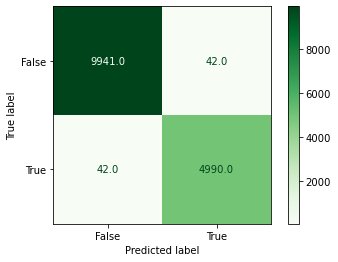

In [25]:
# Kfold implementation, written by Paul Boersma
def kfold_index(df, k=5):
    N = len(df)
    minimum_number_of_points_per_slice = N // k
    remaining_number_of_points = N % k
    starting_point = 0
    out = []
    for islice in range(0, k):
        end_point = starting_point + minimum_number_of_points_per_slice + ( islice < remaining_number_of_points )
        out.append((starting_point, end_point))
        starting_point = end_point
    return out

# Run kfold for given featureset
def execute_kfold(version, feature_type, denoise, k=5):
    acc_train = []
    acc_test = []
    cm = np.zeros((2,2))
    df = build_features(version, feature_type, denoise)
    X, Y = feature_target_split(df)
    for start, end in kfold_index(df, k):
        X_train = np.concatenate((X[:start], X[end:]))
        Y_train = np.concatenate((Y[:start], Y[end:]))
        X_test = X[start:end]
        Y_test = Y[start:end]
        
        model = train(X_train, X_test, Y_train, Y_test, version, feature_type, denoise)
        acc_train.append(model.evaluate(X_train, Y_train, verbose=0)[1])
        acc_test.append(model.evaluate(X_test, Y_test, verbose=0)[1])
        cm += confusion_matrix(Y_test, [1 if prediction > .5 else 0 for prediction in model.predict(X_test)[:,0]])
        
    print('Accuracy on train data:', acc_train, np.mean(acc_train))
    print('Accuracy on test data:', acc_test, np.mean(acc_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])
    disp.plot(cmap="Greens", values_format='')

execute_kfold(1, 'fft', False)

# Live detection

In [14]:
# constants
FORMAT = pyaudio.paFloat32      # audio format (bytes per sample?)
CHANNELS = 1                    # single channel for microphone
SR = 48000                      # samples per second
CHUNK = int((SR / 1000) * STEP) # chunk size
WAVE_OUTPUT_FILENAME = "file.wav"

In [15]:
def live_detect(feature_type, version, denoise, record_seconds=15, write=False):
    # load model
    try:
        model = load_model("model_v" + str(version) + "_" + feature_type + "_" + str(denoise) + ".h5")
    except:
        _, _, model = train_model(version, feature_type, denoise)
    
    # pyaudio class instance
    p = pyaudio.PyAudio()
    buffer = [False] * 10

    # stream object to get data from microphone
    stream = p.open(
        format=FORMAT,
        channels=CHANNELS,
        rate=SR,
        input=True,
        output=True,
        frames_per_buffer=CHUNK
    )

    print("recording...")
    frames = []

    for i in range(0, int(SR / CHUNK * record_seconds)):
        # read chunk
        data = stream.read(CHUNK)
        frames.append(data)
        
        # fetch features
        sample = np.frombuffer(data, dtype=np.float32)
        if feature_type == "fft":
            features = np.mean(np.abs(librosa.stft(sample, n_fft=512, hop_length=256, win_length=512)).T, axis=0)
        elif feature_type == "mfcc":
            features = np.mean(librosa.feature.mfcc(y=sample, sr=SR, n_mfcc=40).T, axis=0)
        
        # make prediction
        features = np.expand_dims(features, axis=0)
        is_whistle = model.predict(features, verbose=0)[0][0]
        
        # print current certainty
        buffer.pop(0)
        buffer.append(is_whistle > .5)
        clear_output(wait=True)
        print("whistle likelihood:", str((sum(buffer)/len(buffer)) * 100) + "%")
        
        
    print("finished recording")

    # stop recording
    stream.stop_stream()
    stream.close()
    p.terminate()

    # write to file
    if write:       
        waveFile = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
        waveFile.setnchannels(CHANNELS)
        waveFile.setsampwidth(p.get_sample_size(FORMAT))
        waveFile.setframerate(SR)
        waveFile.writeframes(b''.join(frames))
        waveFile.close()
        
live_detect("fft", 1, True, write=False)

whistle likelihood: 100.0%
finished recording
